# Assignment set 2 

#### Job Marcelis, Ernani Hazbolatow, Koen Verlaan

To generate the plots and animations, the functions from the `.py` files in the `src` folder are imported. 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from src.gray_scott import plot_gray_scott, animate_gray_scott
from src.diffusion import plot_many_dla, compute_fractal_dimensions, stochastic_runs_fd, optimal_omega_eta
from src.mc_dla import run_single_mc_dla, compute_fractal_dimensions_mc_dla
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 120

### Exercise 2.1: Diffusion Limited Aggregation

This section explores the concept of Diffusion Limited Aggregation (DLA), a process where particles randomly move and aggregate to form clusters.
The code simulates DLA by releasing particles that stick to an existing seed cluster.
The fractal dimension is computed to characterize the branching patterns formed with varying growth bias parameters ($\eta$).

In [ ]:
plot_many_dla((100, 100), [0, 1, 2], 1000)

Plot the fractal dims

In [ ]:
# Run for single iterations
eta_values = np.linspace(0.5, 2.0, 10)  
eta_vals, fractal_dims = compute_fractal_dimensions(eta_values)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(eta_vals, fractal_dims, marker='o', linestyle='-', label="Fractal Dimension")
plt.xlabel("η (Growth Bias Parameter)")
plt.ylabel("Fractal Dimension D")
plt.title("Fractal Dimension vs. η")
plt.legend()
plt.grid()
plt.show()

Plot fractal dimensions for multiple runs at different eta values

In [ ]:
# Run the function with multiple stochastic trials
eta_values = np.linspace(0, 2, 13)  
eta_vals, fractal_means, fractal_stds = stochastic_runs_fd(eta_values, runs=25, grid_size=(100,100))

# Save them into a .npz file. 
np.savez("stochastic_fractal100by100_extra.npz", eta_vals=eta_vals, fractal_means=fractal_means, fractal_stds=fractal_stds)


In [ ]:
data = np.load("data_set2/stoch_fractalD_100x100.npz")

# Extract them
eta_vals = data["eta_vals"]
fractal_means = data["fractal_means"]
fractal_stds = data["fractal_stds"]

# Plot the results with error bars
plt.figure(figsize=(7, 5), dpi=300)
plt.errorbar(eta_vals, fractal_means, yerr=1.96*fractal_stds/np.sqrt(25), color='blue', fmt='o', ecolor='gray', elinewidth=2, capsize=4)
plt.xlabel("Growth Bias Parameter η", fontsize=15)
plt.ylabel("Fractal Dimension D", fontsize=15)
plt.title("Fractal Dimension vs. η", fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()


Plot a 3D plot of the fractal dimension as a function of η and ω

In [ ]:
grid_shape = (100, 100)
eta_values = np.linspace(0, 2.0, 10)       # 10 values for eta from 0.5 to 2.0
omega_values = np.linspace(1.7, 1.99, 10)       # 10 values for omega from 1.0 to 1.9
growth_steps = 3000

# Run experiments for each combination of eta and omega.
avg_iters = optimal_omega_eta(grid_shape, eta_values, omega_values, growth_steps=growth_steps)

# Create a meshgrid for plotting.
Omega, Eta = np.meshgrid(omega_values, eta_values)

In [ ]:
# 3D Mesh Plot: x-axis: omega, y-axis: eta, z-axis: average iterations.
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Omega, Eta, avg_iters, cmap='inferno', edgecolor='none')
ax.set_xlabel("ω", fontsize=19)
ax.set_ylabel("η", fontsize=19)
ax.set_zlabel("Average SOR Iterations", fontsize=17)
ax.set_title(f"Average SOR Iterations vs. ω and η", fontsize=19)
ax.tick_params(axis='both', which='major', labelsize=13) 
ax.tick_params(axis='z', which='major', labelsize=13)
ax.set_xlim(max(Omega.flatten()), min(Omega.flatten()))
cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
cbar.set_label("Iteration Count", fontsize=15)
plt.show()

### Exercise 2.2: Monte Carlo DLA
This section investigates Monte Carlo Diffusion Limited Aggregation (MC-DLA), a stochastic variant of DLA.
The code simulates MC-DLA by releasing particles that have a probability ($p_s$) of sticking to the cluster upon contact.
The fractal dimension is computed to analyze the impact of the sticking probability on the aggregate's structure.

Running for sticking probability: 0.2
Running for sticking probability: 0.4
Running for sticking probability: 0.6
Running for sticking probability: 0.8
Running for sticking probability: 1


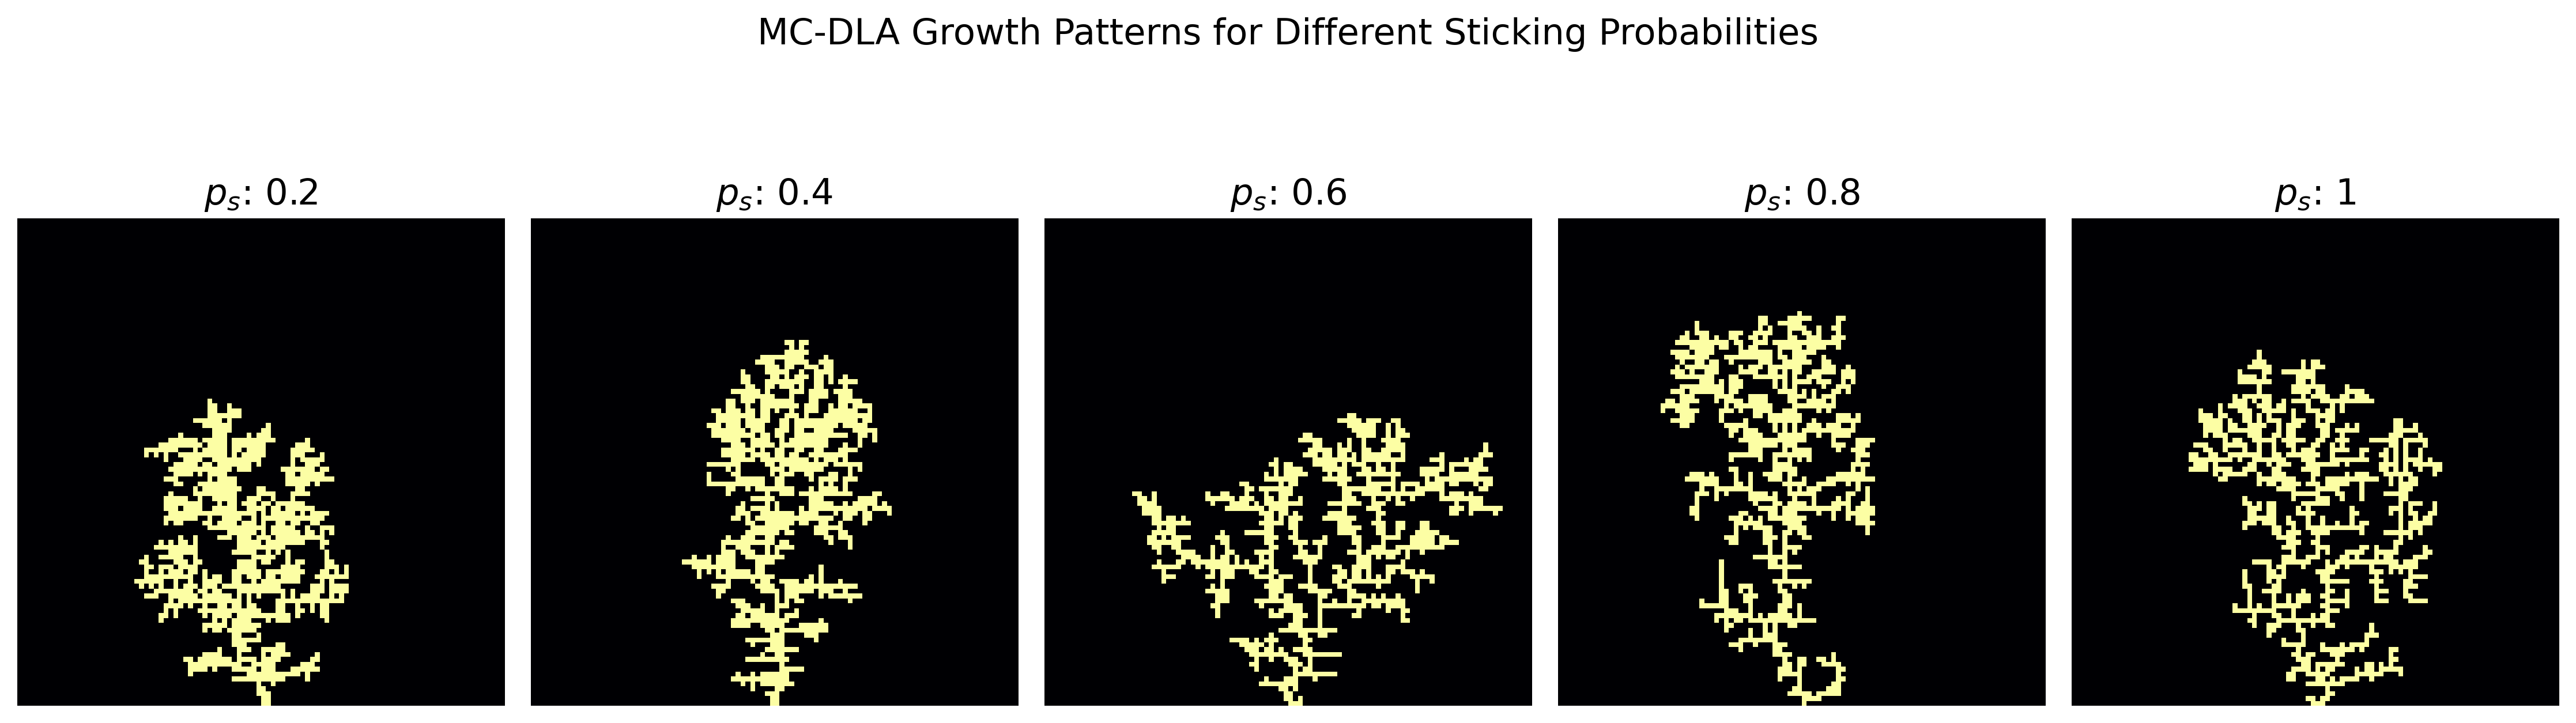

In [ ]:
grid_size = 100
iterations = 50000
max_growth_steps = 1000
probs = [0.2, 0.4, 0.6, 0.8, 1]

plt.figure(figsize=(15, 5), dpi=300)
for i, sticking_prob in enumerate(probs):
    print(f'Running for sticking probability: {sticking_prob}')
    plt.subplot(1, len(probs), i + 1) 
    for _ in range(1):
        steps, grid = run_single_mc_dla(grid_size, max_growth_steps, iterations, sticking_prob, show_animation=False, show_walkers=False, show_final=False)
    plt.imshow(grid, cmap='inferno')
    plt.title(f'$p_s$: {sticking_prob}', fontsize=15)
    plt.axis('off')
    
plt.suptitle('MC-DLA Growth Patterns for Different Sticking Probabilities', fontsize=15)
plt.tight_layout()

Calculate the fractal dimensions for the MC-DLA patterns.

In [ ]:
grid_size = 100
iterations = 50000
max_growth_steps = 1000
probs = np.linspace(0.1, 1, 10)

# Run the MC-DLA for each sticking probability
fractal_dims = {p: [] for p in probs}

for i, sticking_prob in enumerate(probs):
    print(f'Running for sticking probability: {sticking_prob}')
    for _ in range(25):
            steps, grid = run_single_mc_dla(grid_size, max_growth_steps, iterations, sticking_prob, show_animation=False, show_walkers=False, show_final=False)
            # Append the fractal dimension to the list for this probability
            fractal_dims[sticking_prob].append(compute_fractal_dimensions_mc_dla(grid))

# Plot fractal dims
plt.figure(figsize=(7, 5), dpi=300)
means = [np.mean(fractal_dims[p]) for p in probs]
stds = [np.std(fractal_dims[p]) for p in probs]
plt.errorbar(probs, means, yerr=1.96*(stds/np.sqrt(25)), fmt='o', capsize=4, ecolor='grey', color='blue', elinewidth=2)

plt.xlabel('Sticking Probability ($p_s$)', fontsize=15)
plt.ylabel('Fractal Dimension D', fontsize=15)
plt.title('Fractal Dimension vs. $p_s$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.tight_layout()
plt.grid(True, linestyle='--')
plt.ylim(1.2, 1.8)
plt.show()

### Exercise 2.3: The Gray-Scott model

The Gray-Scott model describes a system of chemical reaction where two different species $U$ and $V$ are present. The corresponding reaction-diffusion equations are:
\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla^2 u - u v^2 + f(1 - u), \\
\frac{\partial v}{\partial t} &= D_v \nabla^2 v + u v^2 - (f + k)v.
\end{align}

where $D_u$ and $D_v$ are diffusion constants, $f$ is the rate at which $U$ is supplied, and $f+k$ is the rate at which $V$ decays.

In this experiment, we will investigate different parameter values for $f$ and $k$ and plot/animate the resulting concentration of the species $U$. Below are some parameters that can be modified by the user, including grid size $N$, $dx$, and $dt$

In [ ]:
num_frames = 100

N = 300
dx = 1
dt = 1

Below we have four different parameter combinations. The first two values represent $D_u$ and $D_v$, which are fixed, and the last two values represent $f$ and $k$. The latter three patterns ($\theta$, $\lambda$, and $\mu$) are from J. E. Pearson, SCIENCE, 1993.

In [ ]:
# Original (parameter combination listed in assignment)
param_comb_1 = np.array([0.16, 0.08, 0.035, 0.060], dtype=float)
# theta pattern
param_comb_2 = np.array([0.16, 0.08, 0.04, 0.06], dtype=float)
# lambda pattern
param_comb_3 = np.array([0.16, 0.08, 0.04, 0.065], dtype=float)
# mu pattern
param_comb_4 = np.array([0.16, 0.08, 0.05, 0.065], dtype=float)

We now plot each parameter combination at three different time steps:

In [ ]:
# Plot original pattern
ori_grid = plot_gray_scott(times=[1000, 5000, 15000], N=N, dx=dx, dt=dt, params=param_comb_1)

In [ ]:
# Plot theta pattern
theta_grid = plot_gray_scott(times=[1000, 5000, 15000], N=N, dx=dx, dt=dt, params=param_comb_2)

In [ ]:
# Plot lambda pattern
lambda_grid = plot_gray_scott(times=[2000, 8000, 30000], N=N, dx=dx, dt=dt, params=param_comb_3)

In [ ]:
# Plot mu pattern
mu_grid = plot_gray_scott(times=[5000, 50000, 150000], N=N, dx=dx, dt=dt, params=param_comb_4)

Now we only plot the last frame of the latter three patterns:

In [ ]:
plt.figure(figsize=(20, 6), dpi=300)
plt.suptitle(fr'Concentration of U, $D_u = {{{param_comb_1[0]}}}$, $D_v = {{{param_comb_1[1]}}}$', fontsize=19)

plt.subplot(1, 3, 1)
plt.title(fr'$\theta$-pattern, $f = {{{param_comb_2[2]}}}$, $k = {{{param_comb_2[3]}}}$', fontsize=17)
plt.imshow(theta_grid[:, :, 0], extent=[0, N, 0, N], cmap='inferno')
plt.xlabel('x', fontsize=17)
plt.ylabel('y', fontsize=17)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Concentration U', fontsize=17)

plt.subplot(1, 3, 2)
plt.title(fr'$\lambda$-pattern, $f = {{{param_comb_3[2]}}}$, $k = {{{param_comb_3[3]}}}$', fontsize=17)
plt.imshow(lambda_grid[:, :, 0], extent=[0, N, 0, N], cmap='inferno')
plt.xlabel('x', fontsize=17)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Concentration U', fontsize=17)

plt.subplot(1, 3, 3)
plt.title(fr'$\mu$-pattern, $f = {{{param_comb_4[2]}}}$, $k = {{{param_comb_4[3]}}}$', fontsize=17)
plt.imshow(mu_grid[:, :, 0], extent=[0, N, 0, N], cmap='inferno')
plt.xlabel('x', fontsize=17)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Concentration U', fontsize=17)

plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

Since the evolution of the system can hard to visualise with static plots, we have implemented functionality to animate the system.

In [ ]:
ani1 = animate_gray_scott(num_frames=num_frames, time=15000, N=N, dx=dx, dt=dt, params=param_comb_1)
HTML(ani1.to_jshtml())

In [ ]:
ani2 = animate_gray_scott(num_frames=num_frames, time=15000, N=N, dx=dx, dt=dt, params=param_comb_2)
HTML(ani2.to_jshtml())

In [ ]:
ani3 = animate_gray_scott(num_frames=num_frames, time=30000, N=N, dx=dx, dt=dt, params=param_comb_3)
HTML(ani3.to_jshtml())

In [ ]:
ani4 = animate_gray_scott(num_frames=num_frames, time=150000, N=N, dx=dx, dt=dt, params=param_comb_4)
HTML(ani4.to_jshtml())